In [1]:
# %matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Instructions/Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from today

one_yearAgo = dt.date(2017,8,23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date > one_yearAgo).\
                    group_by(Measurement.date).all()
# precipitation_data

# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(precipitation_data)

# Replacing the "NaN" values by 0
precipitation_df.fillna(value= 0, inplace=True)

#Setting "date" as index #### WHY WHEN I USE THE INDEX THE GRAPH DOES NOT WORK?????????
precipitation_df = precipitation_df.set_index("date")
            
precipitation_df.head()

,prcp
date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,0.00
2016-08-28,2.07


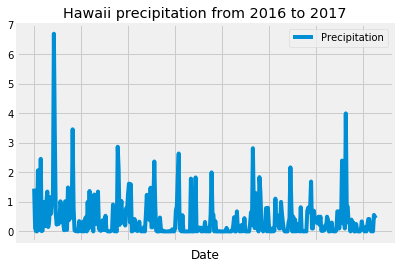

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data

# plt.scatter("date","prcp",facecolors="blue",edgecolors="black") 
# plt.xlabel("date")
# plt.ylabel("prcp")
# plt.title("Date vs. Precipitation",fontsize=14)
# plt.grid(True)
# plt.xticks(rotation=45)
# # plt.savefig("Date vs. Precipitation")
# plt.show()


precipitation_df.plot()
plt.xlabel('Date')
# plt.ylabel('Precipitation')
plt.title('Hawaii precipitation from 2016 to 2017')
plt.xticks(rotation = 45)
plt.legend(["Precipitation"],loc='upper right')
# plt.legend('Precipitation')
# plt.figure(figsize=(10,10))
# plt.tight_layout
plt.savefig("Hawaii_Precipitation_2016_to_2017")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,365.000000
mean,0.406493
std,0.691942
min,0.000000
25%,0.000000
50%,0.110000
75%,0.530000
max,6.700000


In [13]:
# How many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all()
station_count

[(9)]

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
most_active_station = station_count[0][0]
most_active_station

'USC00519281'

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

min_temp = session.query(func.min(Measurement.tobs)).all()
max_temp = session.query(func.max(Measurement.tobs)).all()
avg_temp = session.query(func.avg(Measurement.tobs)).all()

min_max_avg= []

min_max_avg.extend((min_temp[0], max_temp[0], avg_temp[0]))
min_max_avg


# min_max_avg = [min_temp, max_temp, avg_temp]
# min_max_avg

# type(min_temp)
# print(max_temp)
# print(avg_temp)

[(53.0), (87.0), (73.09795396419437)]

In [17]:
# Choose the station with the highest number of temperature observations.
hi_temp_obser = session.query(Measurement.station,Measurement.tobs,func.count(Measurement.tobs)).\
                group_by(Measurement.tobs, Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
hi_temp_obser

('USC00519523', 76.0, 349)

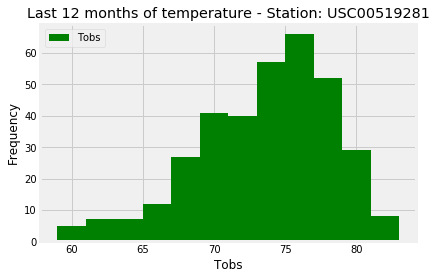

In [30]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_month_temp = session.query(Measurement.station, Measurement.date, Measurement.tobs)\
                    .filter(Measurement.station == most_active_station).filter(Measurement.date > one_yearAgo).all()
# last_12_month_temp

temperature = []

for row in last_12_month_temp:
    temperature.append(row[2])

plt.hist(temperature, bins=12, label = 'Tobs', color='green')
plt.title("Last 12 months of temperature - Station: {}".format(most_active_station))
plt.ylabel("Frequency")
plt.xlabel("Tobs")
plt.legend(loc='upper left')
plt.savefig("USC00519281 - Last 12 month of Temperature")
plt.show()

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
start_date = "2015-12-23"
end_date= "2016-01-03"
# for your trip using the previous year's data for those same dates.

# year_ago = calc_temps - dt.timedelta(days = 365)
Tmin, Tavg, Tmax = calc_temps(start_date, end_date )[0]
# Test 
print(Tmin, Tavg, Tmax)

62.0 71.98550724637681 79.0


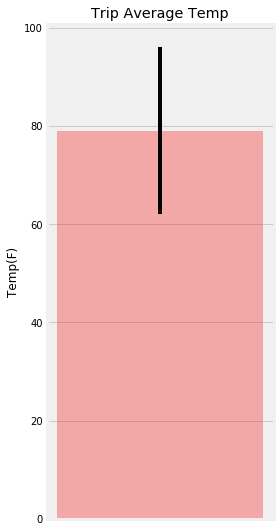

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


fig, ax = plt.subplots(figsize = plt.figaspect(1.9))
xpos = 1 
yerr= Tmax-Tmin
ax.bar(xpos,Tmax, yerr= yerr, alpha = 0.3, color = 'red')
ax.set_title("Trip Average Temp")
ax.set_ylabel("Temp(F)")
# fig.set_figwidth(3)
# fig.set_figheight(7)
fig.tight_layout()
ax.set_xticks([])
plt.savefig("Trip Average Temperature")
plt.show()

In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_station = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

print(rainfall_station)

[('USC00516128', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 12.459999999999999), ('USC00516128', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 12.459999999999999), ('USC00516128', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 12.459999999999999), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 12.459999999999999), ('USC00516128', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 12.459999999999999), ('USC00516128', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 12.459999999999999), ('USC00516128', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 12.459999999999999), ('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 12.459999999999999), ('USC00516128', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 12.459999999999999)]
